##### Programming Exercise by Jomer Allan G. Barcenilla Based on:
UNDERSTANDING DEEP LEARNING REQUIRES RETHINKING GENERALIZATION
- Chiyuan Zhang, Samy Bengio, Moritz Hardt, Benjamin Recht, & Oriol Vinyals

### Import Libraries

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, MaxPooling2D, AveragePooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler

### Import Dataset

In [2]:
# Configurations
tf.random.set_seed(24)

num_classes = 10
lr = 0.01
epochs = 80
batch_size = 16


In [3]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize and shuffle the data
train_images, train_labels = tf.image.per_image_standardization(train_images), train_labels
test_images, test_labels = tf.image.per_image_standardization(test_images), test_labels

# Split the data into training and validation sets
val_split = 0.1
val_size = int(val_split * len(train_images))

val_images = train_images[:val_size]
val_labels = train_labels[:val_size]

train_images = train_images[val_size:]
train_labels = train_labels[val_size:]

### Create the Inception Model

In [4]:
# Convolution module
def conv_block(x, out_channels, kernel_size, strides, padding):
    x = Conv2D(out_channels, kernel_size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Inception module
def inception_module(x, ch1, ch3):
    conv1 = conv_block(x, ch1, (3, 3), (1, 1), 'same')
    conv2 = conv_block(x, ch3, (3, 3), (1, 1), 'same')
    inception = Concatenate(axis=-1)([conv1, conv2])
    return inception

# Downsample module
def downsample_module(x, ch3):
    conv1 = conv_block(x, ch3, (3, 3), (2, 2), 'same')
    maxpool = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    x = Concatenate(axis=-1)([conv1, maxpool])
    return x

# Build the model
inputs = Input(shape=(32, 32, 3))
x = conv_block(inputs, 96, (3, 3), (1, 1), 'same')
x = inception_module(x, 32, 32)
x = inception_module(x, 32, 48)
x = downsample_module(x, 80)
x = inception_module(x, 112, 48)
x = inception_module(x, 96, 64)
x = inception_module(x, 80, 80)
x = inception_module(x, 48, 96)
x = downsample_module(x, 96)
x = inception_module(x, 176, 160)
x = inception_module(x, 176, 160)

x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs)

In [5]:
# Show model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 96)           2688      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 96)           384       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 96)           0         ['batch_normalization[0][0

### Model Training

In [6]:
# Compile the model
model.compile(optimizer=SGD(learning_rate=lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Training
train_start = time.time()
history = model.fit(train_images, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(val_images, val_labels),
                    callbacks=[LearningRateScheduler(lambda epoch: lr * (1 - epoch / epochs))])

train_time = time.time() - train_start
print(f"Total training time: {train_time:.2f} seconds")

Epoch 1/80
2813/2813 [==============================] - 79s 21ms/step - loss: 1.3014 - accuracy: 0.5328 - val_loss: 1.1935 - val_accuracy: 0.5916 - lr: 0.0100
Epoch 2/80
2813/2813 [==============================] - 57s 20ms/step - loss: 0.8698 - accuracy: 0.6980 - val_loss: 0.8111 - val_accuracy: 0.7130 - lr: 0.0099
Epoch 3/80
2813/2813 [==============================] - 58s 21ms/step - loss: 0.6830 - accuracy: 0.7627 - val_loss: 0.9604 - val_accuracy: 0.6784 - lr: 0.0098
Epoch 4/80
2813/2813 [==============================] - 56s 20ms/step - loss: 0.5652 - accuracy: 0.8069 - val_loss: 0.7026 - val_accuracy: 0.7626 - lr: 0.0096
Epoch 5/80
2813/2813 [==============================] - 56s 20ms/step - loss: 0.4746 - accuracy: 0.8363 - val_loss: 0.7795 - val_accuracy: 0.7424 - lr: 0.0095
Epoch 6/80
2813/2813 [==============================] - 56s 20ms/step - loss: 0.3981 - accuracy: 0.8642 - val_loss: 0.7004 - val_accuracy: 0.7720 - lr: 0.0094
Epoch 7/80
2813/2813 [========================

### Model Testing

In [8]:
# Testing
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=batch_size)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

625/625 [==============================] - 4s 7ms/step - loss: 0.6345 - accuracy: 0.8589

Test Loss: 0.6345
Test Accuracy: 85.89%


In [9]:
# Save all results to a DataFrame for export
df_res = pd.DataFrame()
df_res['TrainAccuracy'] = history.history['accuracy']
df_res['TrainLoss'] = history.history['loss']
df_res['ValidationAccuracy'] = history.history['val_accuracy']
df_res['ValidationLoss'] = history.history['val_loss']
df_res['EpochTime'] = [time.time() - ep_start for ep_start in history.epoch]
df_res['Totaltime'] = train_time
df_res['TestAccuracy'] = test_accuracy
df_res['TestLoss'] = test_loss

# Export results to CSV
df_res.to_csv('results.csv', index=False)

In [10]:
# Show the highest accuracy
max_accuracy = history.history['val_accuracy'][-1]
print(f"\nHighest validation accuracy reached: {max_accuracy * 100:.2f}%")


Highest validation accuracy reached: 86.42%


In [11]:
# Testing with Confusion Matrix
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)

313/313 [==============================] - 4s 9ms/step


In [12]:
# Show the confusion matrix
confusion_matrix = tf.math.confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(confusion_matrix)

Confusion Matrix:
tf.Tensor(
[[885  10  28   9   7   3   7   9  30  12]
 [  7 936   2   2   0   2   3   1  11  36]
 [ 43   1 786  32  39  38  36  17   6   2]
 [ 13   2  49 709  37  96  49  24  11  10]
 [  6   0  37  33 838  14  34  32   4   2]
 [  6   3  27 110  26 791   9  23   3   2]
 [  7   1  29  23  13  12 902   6   5   2]
 [  6   1  20  26  19  19   2 899   1   7]
 [ 36  11   7   6   0   0   1   2 928   9]
 [ 18  33   1   3   2   2   5   6  15 915]], shape=(10, 10), dtype=int32)


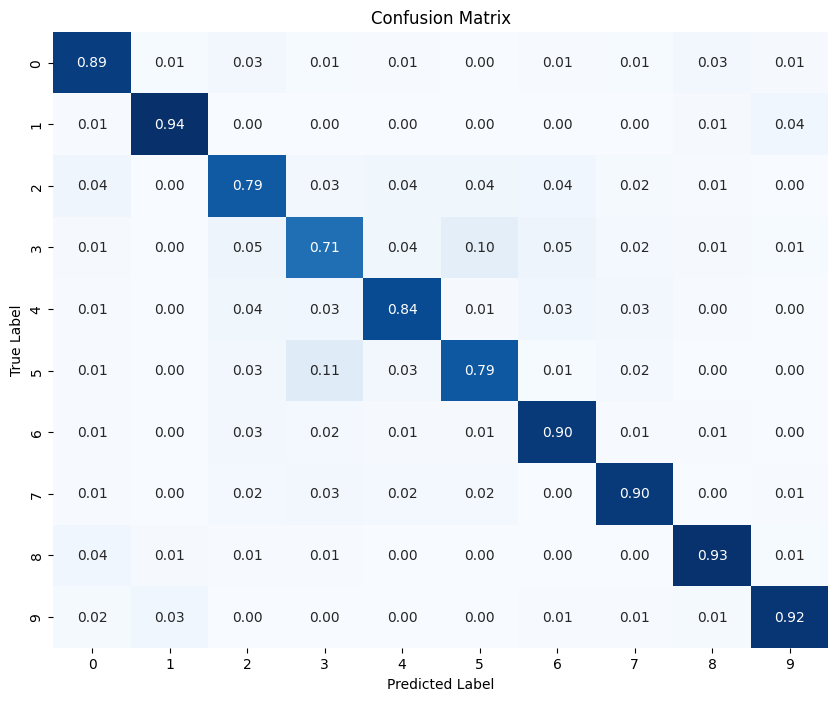

In [13]:
# Plot the confusion matrix

# Get percentages
confusion_matrix_percent = confusion_matrix.numpy() / confusion_matrix.numpy().sum(axis=1, keepdims=True)

# Convert to DataFrame
class_names = [str(i) for i in range(confusion_matrix.shape[0])]
df_cm = pd.DataFrame(confusion_matrix_percent, index=class_names, columns=class_names)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=".2f", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()